In [161]:
import pandas as pd
import numpy as np
import pathlib
import os
import shutil

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

# General data loading for all experiments 

In [162]:
#Identify experiments that are not in the ignore list 
exp_test_description = "LLMP_Experiments"
directory = f"/h/kupfersk/cfpr_2025/generate_forecasts/output/"

ignore_list = [".csv",
               "ipynb",
#                 "llama",
#                 "gemini",
#                 "claude",
#                 "gpt",
               "Mixtral",
               '5th',
               "restaurants",
               "DeepARModel_exp",
               "ChronosModel_exp",
               "PatchTSTModel_exp",
               "DLinearModel_exp",
               "exp7",
               "exp8",
               "corr",
               "economic",
               "human",
#                "GPT_P",
#                "exp2_R"
#                "llm",
#                "exp1",
#                "report", 
#                "covariates",
               
]

experiments_include = []

for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
    if all(keyword not in experiment_name for keyword in ignore_list):
        experiments_include.append(experiment_name)

experiments_include

['gemini-1.5-pro_report_True_with_future_forecasts_True',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'gemini-1.5-pro_report_True',
 'gpt-4o_report_True',
 'llama-3.1-70B_future_forecasts_75_no_headers',
 'gemini-1.5-pro_report_False',
 'claude-3-5-sonnet-20240620_report_False_with_future_forecasts_True',
 'gpt-4o_report_True_with_future_forecasts_True',
 'llama-3.1-70B_prices_only_300_no_headers',
 'llama-3.1-70B_exo_shifted_75_no_headers',
 'claude-3-5-sonnet-20240620_report_True',
 'claude-3-5-sonnet-20240620_report_False',
 'gpt-4o_report_False',
 'gpt-4o_report_False_with_future_forecasts_True']

In [163]:

report_sim_dates = open("../generate_forecasts/experiment_cutoff_dates.txt", 'r').read().split()
# report_sim_dates = report_sim_dates[:1]



llmp_target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Meat',
     'Vegetables and vegetable preparations'
]
target_categories = llmp_target_categories



target_categories = [f"food_cpi: {col}" for col in target_categories]

start_years = [1986]
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))


file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Meat
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01
2023-07-01


### Ensure all necessary data is stored in Experimental_Analysis folder for easy access 

In [164]:
# # Define the source directory (starting from Full_Report)
# source_dir = "../generate_forecasts/output/Full_Report/"
# # No need to hard-code the destination directory here; it will be determined dynamically

# # Walk through the source directory to find the directories that contain '2024-07-01'
# for experiment in os.listdir(source_dir):
#     if experiment in experiments_include:
#         print(experiment)
        
#         for root, dirs, files in os.walk(f"/h/kupfersk/cfpr_2025/generate_forecasts/output/Full_Report/{experiment}"):
#             # Determine the destination directory dynamically by replacing 'Full_Report' with 'Forecasts'
#             new_dest = root.replace("Full_Report", "Experimental_Analysis")

#             # Ensure the destination directory exists, if not, create it
#             os.makedirs(new_dest, exist_ok=True)

#             # Move all files from the current 'root' to the new destination directory
#             for file in files:
#                 if '.csv' in file:
#                     source_file = os.path.join(root, file)
#                     dest_file = os.path.join(new_dest, file)
#                     shutil.copy2(source_file, dest_file)  # Use shutil.move() to move files
#                     print(f"Moved {source_file} to {dest_file}")


### Define evaluation metrics and calculate mape for all periods

In [165]:
# Define the source directory (starting from Full_Report)
source_dir = "../generate_forecasts/output/Experimental_Analysis/"
experiments = experiments_include
experiments

['gemini-1.5-pro_report_True_with_future_forecasts_True',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'gemini-1.5-pro_report_True',
 'gpt-4o_report_True',
 'llama-3.1-70B_future_forecasts_75_no_headers',
 'gemini-1.5-pro_report_False',
 'claude-3-5-sonnet-20240620_report_False_with_future_forecasts_True',
 'gpt-4o_report_True_with_future_forecasts_True',
 'llama-3.1-70B_prices_only_300_no_headers',
 'llama-3.1-70B_exo_shifted_75_no_headers',
 'claude-3-5-sonnet-20240620_report_True',
 'claude-3-5-sonnet-20240620_report_False',
 'gpt-4o_report_False',
 'gpt-4o_report_False_with_future_forecasts_True']

In [166]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [167]:
# import json


# def compute_all_scores(report_sim_dates, study_metric="mape"):
#     global forecast_df
#     global actual_df
#     global predicted_categories
    
#     results = []
    
        
# #     # Load the dictionary from the JSON file
# #     with open('target_category_dict_filt.json', 'r') as json_file:
# #         target_category_dict = json.load(json_file)
        
#     for start_year in start_years:
#         for EXPERIMENT_NAME in experiments:
#             predicted_categories = []
            
#             print(EXPERIMENT_NAME)
#             if 'ag' in EXPERIMENT_NAME :
#                 predicted_categories = target_categories
# #                 if "R" not in EXPERIMENT_NAME:
# #                     if 'exp' in EXPERIMENT_NAME: 
# #                         general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
# #                         predicted_categories_in = target_category_dict[general_experiment]

#                         # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
# #                         predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']


#             for category in predicted_categories:
#                 if "restaurant" in category:
#                     continue 
                    
#                 scores = []

#                 for cutoff_date in report_sim_dates:

#                     forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
#                     forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
#                     forecast_df.index = pd.to_datetime(forecast_df.index)

#                     actual_df = foodprice_df[category].loc[
#                         [
#                             date
#                             for date in forecast_df.index
#                             if date in foodprice_df.index
#                         ]
#                     ]
                    
#                     if report_sim_dates[-1] == cutoff_date:
#                         forecast_df = forecast_df.iloc[:-1]
#                         actual_df = actual_df.iloc[:-1]


#                     if study_metric in point_metrics:
#                         median_col = "q_0.5"
#                         y_pred = forecast_df[median_col]
#                         y_true = actual_df
#                         if len(y_pred) > len(y_true):
#                             y_pred = y_pred[: len(y_true)]
#                         scores.append(
#                             point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
#                         )

#                     elif study_metric == "pinball_loss":
#                         y_pred = forecast_df
#                         y_true = actual_df
#                         if len(y_pred) > len(y_true):
#                             y_pred = y_pred[: len(y_true)]
#                         scores.append(
#                             average_pinball_loss(
#                                 y_true=y_true,
#                                 y_pred_quantiles=y_pred,
#                                 quantiles=[
#                                     0.01,
#                                     0.05,
#                                     0.1,
#                                     0.25,
#                                     0.75,
#                                     0.9,
#                                     0.95,
#                                     0.99,
#                                 ],
#                             )
#                         )

#                 mean_score = np.mean(scores)
#                 std_score = np.std(scores)

#                 results.append(
#                     {   "year": start_year,
#                         "experiment": EXPERIMENT_NAME,
#                         "category": category,
#                         "mean_score": mean_score,
#                         "std_score": std_score,
#                         "scores": scores
#                     }
#                 )

#     return pd.DataFrame(results)


In [168]:
import json


def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df
    global actual_df
    global predicted_categories
    
    results = []
    

        
    for start_year in start_years:



        for EXPERIMENT_NAME in experiments:
            predicted_categories = []
            
            print(EXPERIMENT_NAME)
            if 'ag' in EXPERIMENT_NAME :
                if 'exp' in EXPERIMENT_NAME: 
                    general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
                    predicted_categories_in = target_category_dict[general_experiment]
                    
                    # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
                    predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']
                else:
                    predicted_categories = target_categories
                
            else:
                predicted_categories = [
                                        'food_cpi: Bakery and cereal products (excluding baby food)',
                                         'food_cpi: Meat',
                                         'food_cpi: Vegetables and vegetable preparations'
                                    ]

            for category in predicted_categories:
                if "restaurant" in category:
                    continue 
                    
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]
                    
                    if report_sim_dates[-1] == cutoff_date:
                        forecast_df = forecast_df.iloc[:-1]
                        actual_df = actual_df.iloc[:-1]


                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)



In [169]:
with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
    target_category_dict = json.load(json_file)
    
target_category_dict

{'exp5_geopolitical_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_manufacturing_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_climate_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi

In [170]:
## For classical model experiments 
mape_df = compute_all_scores(report_sim_dates, "mape")
mape_df

# mape_df['path']= "f'./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_42/{cutoff_date}/forecasts/{category}.csv'"
mape_df.experiment.unique()


gemini-1.5-pro_report_True_with_future_forecasts_True
gemini-1.5-pro_report_False_with_future_forecasts_True
claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True
gemini-1.5-pro_report_True
gpt-4o_report_True
llama-3.1-70B_future_forecasts_75_no_headers
gemini-1.5-pro_report_False
claude-3-5-sonnet-20240620_report_False_with_future_forecasts_True
gpt-4o_report_True_with_future_forecasts_True
llama-3.1-70B_prices_only_300_no_headers
llama-3.1-70B_exo_shifted_75_no_headers
claude-3-5-sonnet-20240620_report_True
claude-3-5-sonnet-20240620_report_False
gpt-4o_report_False
gpt-4o_report_False_with_future_forecasts_True


array(['gemini-1.5-pro_report_True_with_future_forecasts_True',
       'gemini-1.5-pro_report_False_with_future_forecasts_True',
       'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
       'gemini-1.5-pro_report_True', 'gpt-4o_report_True',
       'llama-3.1-70B_future_forecasts_75_no_headers',
       'gemini-1.5-pro_report_False',
       'claude-3-5-sonnet-20240620_report_False_with_future_forecasts_True',
       'gpt-4o_report_True_with_future_forecasts_True',
       'llama-3.1-70B_prices_only_300_no_headers',
       'llama-3.1-70B_exo_shifted_75_no_headers',
       'claude-3-5-sonnet-20240620_report_True',
       'claude-3-5-sonnet-20240620_report_False', 'gpt-4o_report_False',
       'gpt-4o_report_False_with_future_forecasts_True'], dtype=object)

# Figure 3. How much more often did global models end up in the top when we used curated variables


Steps:
1) load in all data
2) Do this for TemporalFusionTransformer
3) Repeat for global all and global+covariates 


In [171]:
def assign_type(experiment):
    experiment = experiment.lower()  # Make lowercase for case-insensitive matching
    if 'llama' in experiment:
        return 'Open Source'
    else: 
        return 'Close Source'
   
# Define the function to assign model class based on keywords in experiment names
def assign_inclusion(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for both 'future_forecasts' and 'report_True'
    if '_future_forecasts_true' in experiment and '_report_true' in experiment:
        return 'Future forecasts + CFPR + Exogenous'
    
    if '70b_future_forecasts' in experiment:
        return 'Future forecasts + Exogenous'
    
    # Check only for 'future_forecasts'
    if '_future_forecasts_true' in experiment:
        return 'Future forecasts + Exogenous'

    # Check for LLM models (Chronos in this case)
    elif 'prices' in experiment:
        return 'Local target time series'

    # Check for general deep learning models
    elif 'exo_shifted' in experiment:
        return 'Exogenous'
    
    # Check for statistical models
    elif '_report_true' in experiment:
        return 'CFPR + Exogenous'

    elif '_report_false' in experiment:
        return 'Exogenous'


def assign_selection(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'exp2_r' in experiment:
        return 'Baseline - Random average (n=5)'
    
   # Check for LLM models (Chronos in this case)
    elif 'gpt_p1' in experiment:
        return 'LLM persona - Global affairs speciallist'

    # Check for LLM models (Chronos in this case)
    elif 'gpt_p2' in experiment:
        return 'LLM persona - Economist'

    # Check for general deep learning models
    elif 'gpt_p3' in experiment:
        return 'LLM persona - Agronomist'
    
    # Check for general deep learning models
    elif 'gpt_p4' in experiment:
        return 'LLM persona - average Canadian'
    
    # Check for general deep learning models
    elif 'chronosmodel' in experiment:
        return 'Baseline - Foundation zero-shot'

    # Check for statistical models
    elif 'exp8_' in experiment:
        return 'Baseline - Correlation by category'
    
    # Check for statistical models
    elif 'exp1_' in experiment:
        return 'LLM concenus - across all personas'    
    
def assign_model(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'claude' in experiment:
        return 'Claude-3.5-Sonnet'
    
   # Check for LLM models (Chronos in this case)
    elif 'gemini' in experiment:
        return 'Gemini 1.5 Pro'

    # Check for LLM models (Chronos in this case)
    elif 'gpt' in experiment:
        return 'GPT 4.o'
    
    elif 'llama' in experiment:
        return 'llama 3.1 70B'
    
# Apply the function to add a new column 'condition' in filt_df
mape_df['type'] = mape_df['experiment'].apply(assign_type)
mape_df['inclusion'] = mape_df['experiment'].apply(assign_inclusion)
mape_df['selection'] = mape_df['experiment'].apply(assign_selection)
mape_df['model'] = mape_df['experiment'].apply(assign_model)




mape_df = mape_df.sort_values(by="inclusion")
mape_df['inclusion'].unique()


array(['CFPR + Exogenous', 'Exogenous',
       'Future forecasts + CFPR + Exogenous',
       'Future forecasts + Exogenous', 'Local target time series'],
      dtype=object)

In [172]:
mape_df

,year,experiment,category,mean_score,std_score,scores,type,inclusion,selection,model
33,1986,claude-3-5-sonnet-20240620_report_True,food_cpi: Bakery and cereal products (excludin...,0.031281,0.018077,"[0.02073924951809224, 0.009312911555855808, 0....",Close Source,CFPR + Exogenous,None,Claude-3.5-Sonnet
34,1986,claude-3-5-sonnet-20240620_report_True,food_cpi: Meat,0.017961,0.009506,"[0.01920939420489079, 0.017683947031517683, 0....",Close Source,CFPR + Exogenous,None,Claude-3.5-Sonnet
35,1986,claude-3-5-sonnet-20240620_report_True,food_cpi: Vegetables and vegetable preparations,0.062915,0.019335,"[0.09624755048953425, 0.06851275154273392, 0.0...",Close Source,CFPR + Exogenous,None,Claude-3.5-Sonnet
9,1986,gemini-1.5-pro_report_True,food_cpi: Bakery and cereal products (excludin...,0.037404,0.026553,"[0.020479441745736675, 0.01042740733368304, 0....",Close Source,CFPR + Exogenous,None,Gemini 1.5 Pro
10,1986,gemini-1.5-pro_report_True,food_cpi: Meat,0.029670,0.011370,"[0.012373620220516962, 0.03525317605561321, 0....",Close Source,CFPR + Exogenous,None,Gemini 1.5 Pro
11,1986,gemini-1.5-pro_report_True,food_cpi: Vegetables and vegetable preparations,0.059007,0.026229,"[0.09185547879095758, 0.02343999826260866, 0.0...",Close Source,CFPR + Exogenous,None,Gemini 1.5 Pro
12,1986,gpt-4o_report_True,food_cpi: Bakery and cereal products (excludin...,0.034042,0.021648,"[0.008737717106296169, 0.010787942407354688, 0...",Close Source,CFPR + Exogenous,None,GPT 4.o
13,1986,gpt-4o_report_True,food_cpi: Meat,0.026463,0.013335,"[0.014347548740518317, 0.025909210243961735, 0...",Close Source,CFPR + Exogenous,None,GPT 4.o
14,1986,gpt-4o_report_True,food_cpi: Vegetables and vegetable preparations,0.061838,0.019761,"[0.06343375731344704, 0.08021097608594906, 0.0...",Close Source,CFPR + Exogenous,None,GPT 4.o
39,1986,gpt-4o_report_False,food_cpi: Bakery and cereal products (excludin...,0.035709,0.026182,"[0.007458435780564411, 0.01192078857480809, 0....",Close Source,Exogenous,None,GPT 4.o


### Averaged across all categories

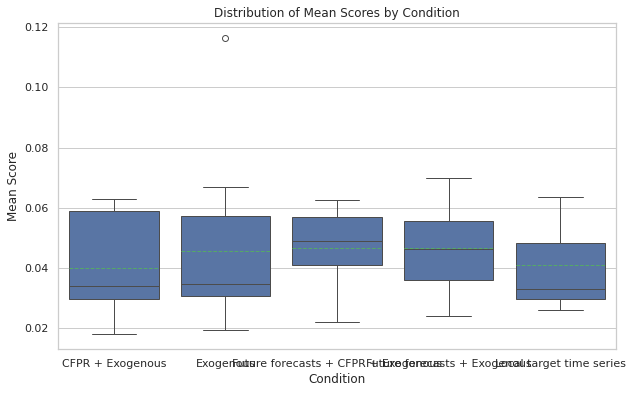

In [173]:
# What if we aggregate across all of the food categories
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Create a boxplot to show the distribution of mean_score across conditions
plt.figure(figsize=(10, 6))
sns.boxplot(data=mape_df, x='inclusion', y='mean_score', showmeans=True, meanline=True)

# Add plot labels and title
plt.title("Distribution of Mean Scores by Condition")
plt.xlabel("Condition")
plt.ylabel("Mean Score")

# Show plot
plt.show()

## By individiual food category

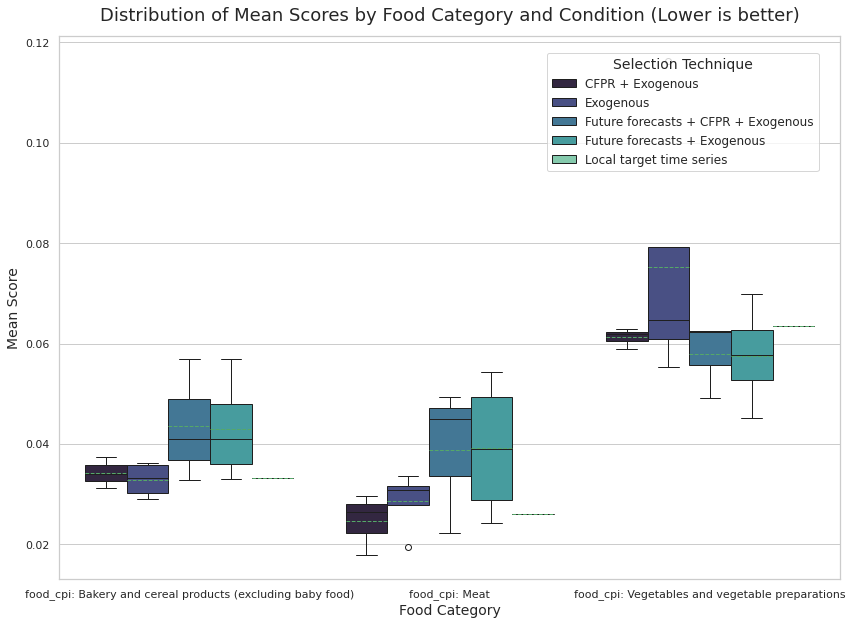

In [174]:
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the Seaborn theme and use the "mako" gradient palette
sns.set_theme(style="whitegrid")
gradient_palette = sns.color_palette("mako", n_colors=mape_df['inclusion'].nunique())

# Create the boxplot with flipped axes
plt.figure(figsize=(14, 10))
sns.boxplot(data=mape_df, x='category', y='mean_score', hue='inclusion', showmeans=True, meanline=True, palette=gradient_palette)

# Customize plot title and labels with larger font sizes
plt.title("Distribution of Mean Scores by Food Category and Condition (Lower is better)", fontsize=18, pad=15)
plt.ylabel("Mean Score", fontsize=14)
plt.xlabel("Food Category", fontsize=14)

# Position legend outside the plot for better readability
plt.legend(title='Selection Technique', loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=12, title_fontsize=14, frameon=True)

# Display the plot
plt.show()


In [175]:
import pandas as pd

# Assuming mape_df is the DataFrame with 'model', 'inclusion', and 'mean_score'

# Group by 'model' and 'inclusion' to calculate mean and std
pivot_table = mape_df.groupby(['model', 'category'])['mean_score'].agg(
    mean='mean',
    std='std'
).reset_index()

# Format the mean and std as "mean ± std"
pivot_table['mean_std'] = pivot_table.apply(lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1)

# Pivot the table to get 'inclusion' as columns
pivot_table = pivot_table.pivot(index='model', columns='category', values='mean_std').reset_index()



# Display the final pivot table
pivot_table.set_index('model')


category,food_cpi: Bakery and cereal products (excluding baby food),food_cpi: Meat,food_cpi: Vegetables and vegetable preparations
model,,,
Claude-3.5-Sonnet,0.031 ± 0.002,0.021 ± 0.003,0.058 ± 0.008
GPT 4.o,0.043 ± 0.010,0.039 ± 0.011,0.062 ± 0.001
Gemini 1.5 Pro,0.043 ± 0.010,0.040 ± 0.012,0.077 ± 0.027
llama 3.1 70B,0.034 ± 0.003,0.029 ± 0.003,0.055 ± 0.009


In [176]:
mape_df = mape_df.reset_index()

In [177]:

# Group by 'category', 'type', and 'inclusion' to calculate mean and std
summary_table = mape_df.groupby(['category', 'type', 'inclusion'])['mean_score'].agg(
    mean='mean',
    std='std'
).reset_index()

# Format the mean and std as "mean ± std"
summary_table['mean_std'] = summary_table.apply(lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1)

# Pivot the table to have each inclusion condition as a column
summary_table_pivot = summary_table.pivot(index=['category', 'type'], columns='inclusion', values='mean_std').reset_index()

# Reorder the columns to match the specified order
order = ['Exogenous', 'Future forecasts + Exogenous', 'CFPR + Exogenous', 'Future forecasts + CFPR + Exogenous']
summary_table_pivot = summary_table_pivot[['category', 'type'] + order]

# Display the table with a hierarchical index on 'category' and 'type'
summary_table_final = summary_table_pivot.set_index(['category', 'type'])

# Display the final table
summary_table_final

inclusion                                                            Exogenous  \
category                                           type                          
food_cpi: Bakery and cereal products (excluding... Close Source  0.034 ± 0.004   
                                                   Open Source     0.031 ± nan   
food_cpi: Meat                                     Close Source  0.028 ± 0.007   
                                                   Open Source     0.031 ± nan   
food_cpi: Vegetables and vegetable preparations    Close Source  0.082 ± 0.030   
                                                   Open Source     0.055 ± nan   

inclusion                                                       Future forecasts + Exogenous  \
category                                           type                                        
food_cpi: Bakery and cereal products (excluding... Close Source                0.045 ± 0.012   
                                                   Open Source                   0.037 ± nan   
food_cpi: Meat                                     Close Source                0.042 ± 0.016   
                                                   Open Source                   0.030 ± nan   
food_cpi: Vegetables and vegetable preparations    Close Source                0.062 ± 0.008   
                                                   Open Source                   0.045 ± nan   

inclusion                                                       CFPR + Exogenous  \
category                                           type                            
food_cpi: Bakery and cereal products (excluding... Close Source    0.034 ± 0.003   
                                                   Open Source               NaN   
food_cpi: Meat                                     Close Source    0.025 ± 0.006   
                                                   Open Source               NaN   
food_cpi: Vegetables and vegetable preparations    Close Source    0.061 ± 0.002   
                                                   Open Source               NaN   

inclusion                                                       Future forecasts + CFPR + Exogenous  
category                                           type                                              
food_cpi: Bakery and cereal products (excluding... Close Source                       0.044 ± 0.012  
                                                   Open Source                                  NaN  
food_cpi: Meat                                     Close Source                       0.039 ± 0.015  
                                                   Open Source                                  NaN  
food_cpi: Vegetables and vegetable preparations    Close Source                       0.058 ± 0.008  
                                                   Open Source                                  NaN

In [178]:
summary_table

,category,type,inclusion,mean,std,mean_std
0,food_cpi: Bakery and cereal products (excludin...,Close Source,CFPR + Exogenous,0.034242,0.003066,0.034 ± 0.003
1,food_cpi: Bakery and cereal products (excludin...,Close Source,Exogenous,0.033651,0.004038,0.034 ± 0.004
2,food_cpi: Bakery and cereal products (excludin...,Close Source,Future forecasts + CFPR + Exogenous,0.043527,0.012249,0.044 ± 0.012
3,food_cpi: Bakery and cereal products (excludin...,Close Source,Future forecasts + Exogenous,0.044982,0.012031,0.045 ± 0.012
4,food_cpi: Bakery and cereal products (excludin...,Open Source,Exogenous,0.030651,NaN,0.031 ± nan
5,food_cpi: Bakery and cereal products (excludin...,Open Source,Future forecasts + Exogenous,0.037166,NaN,0.037 ± nan
6,food_cpi: Bakery and cereal products (excludin...,Open Source,Local target time series,0.033145,NaN,0.033 ± nan
7,food_cpi: Meat,Close Source,CFPR + Exogenous,0.024698,0.006050,0.025 ± 0.006
8,food_cpi: Meat,Close Source,Exogenous,0.027923,0.007458,0.028 ± 0.007
9,food_cpi: Meat,Close Source,Future forecasts + CFPR + Exogenous,0.038835,0.014520,0.039 ± 0.015


## Comparing by model

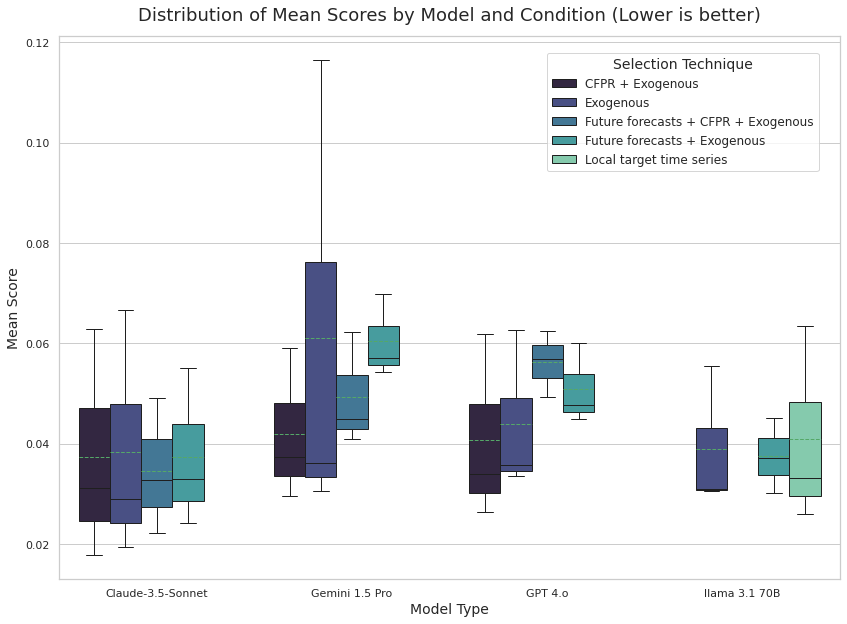

In [179]:
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the Seaborn theme and use the "mako" gradient palette
sns.set_theme(style="whitegrid")
gradient_palette = sns.color_palette("mako", n_colors=mape_df['inclusion'].nunique())

# Create the boxplot with flipped axes
plt.figure(figsize=(14, 10))
sns.boxplot(data=mape_df, x='model', y='mean_score', hue='inclusion', showmeans=True, meanline=True, palette=gradient_palette)

# Customize plot title and labels with larger font sizes
plt.title("Distribution of Mean Scores by Model and Condition (Lower is better)", fontsize=18, pad=15)
plt.ylabel("Mean Score", fontsize=14)
plt.xlabel("Model Type", fontsize=14)

# Position legend outside the plot for better readability
plt.legend(title='Selection Technique', loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=12, title_fontsize=14, frameon=True)

# Display the plot
plt.show()


In [180]:
mape_df.groupby(['model', 'inclusion'])['mean_score'].agg(
    mean='mean',
    std='std',
    min='min',
    max='max',
    median='median'
).reset_index()

,model,inclusion,mean,std,min,max,median
0,Claude-3.5-Sonnet,CFPR + Exogenous,0.037386,0.023090,0.017961,0.062915,0.031281
1,Claude-3.5-Sonnet,Exogenous,0.038408,0.025000,0.019479,0.066748,0.028999
2,Claude-3.5-Sonnet,Future forecasts + CFPR + Exogenous,0.034693,0.013513,0.022256,0.049071,0.032751
3,Claude-3.5-Sonnet,Future forecasts + Exogenous,0.037442,0.015932,0.024231,0.055135,0.032959
4,GPT 4.o,CFPR + Exogenous,0.040781,0.018625,0.026463,0.061838,0.034042
5,GPT 4.o,Exogenous,0.044024,0.016256,0.033607,0.062755,0.035709
6,GPT 4.o,Future forecasts + CFPR + Exogenous,0.056226,0.006650,0.049285,0.062542,0.056850
7,GPT 4.o,Future forecasts + Exogenous,0.050935,0.008106,0.044967,0.060164,0.047675
8,Gemini 1.5 Pro,CFPR + Exogenous,0.042027,0.015205,0.029670,0.059007,0.037404
9,Gemini 1.5 Pro,Exogenous,0.061095,0.047939,0.030683,0.116357,0.036244


In [181]:
import pandas as pd

# Assuming mape_df is the DataFrame containing your data

# Group by 'model' and 'inclusion' and calculate summary statistics for 'mean_score'
summary_table = mape_df.groupby(['model', 'inclusion'])['mean_score'].agg(
    mean='mean',
    std='std',
    min='min',
    max='max',
    median='median'
).reset_index()

# Display the table
summary_table


,model,inclusion,mean,std,min,max,median
0,Claude-3.5-Sonnet,CFPR + Exogenous,0.037386,0.023090,0.017961,0.062915,0.031281
1,Claude-3.5-Sonnet,Exogenous,0.038408,0.025000,0.019479,0.066748,0.028999
2,Claude-3.5-Sonnet,Future forecasts + CFPR + Exogenous,0.034693,0.013513,0.022256,0.049071,0.032751
3,Claude-3.5-Sonnet,Future forecasts + Exogenous,0.037442,0.015932,0.024231,0.055135,0.032959
4,GPT 4.o,CFPR + Exogenous,0.040781,0.018625,0.026463,0.061838,0.034042
5,GPT 4.o,Exogenous,0.044024,0.016256,0.033607,0.062755,0.035709
6,GPT 4.o,Future forecasts + CFPR + Exogenous,0.056226,0.006650,0.049285,0.062542,0.056850
7,GPT 4.o,Future forecasts + Exogenous,0.050935,0.008106,0.044967,0.060164,0.047675
8,Gemini 1.5 Pro,CFPR + Exogenous,0.042027,0.015205,0.029670,0.059007,0.037404
9,Gemini 1.5 Pro,Exogenous,0.061095,0.047939,0.030683,0.116357,0.036244


In [182]:
import pandas as pd

# Assuming mape_df is the DataFrame with 'model', 'inclusion', and 'mean_score'

# Group by 'model' and 'inclusion' to calculate mean and std
pivot_table = mape_df.groupby(['model', 'inclusion'])['mean_score'].agg(
    mean='mean',
    std='std'
).reset_index()

# Format the mean and std as "mean ± std"
pivot_table['mean_std'] = pivot_table.apply(lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1)

# Pivot the table to get 'inclusion' as columns
pivot_table = pivot_table.pivot(index='model', columns='inclusion', values='mean_std').reset_index()

# Define the order of columns
order = ['Exogenous', 'Future forecasts + Exogenous', 'CFPR + Exogenous' , 'Future forecasts + CFPR + Exogenous']

# Reorder the columns based on the specified order
pivot_table = pivot_table[['model'] + order]

# Display the final pivot table
pivot_table.set_index('model')


inclusion,Exogenous,Future forecasts + Exogenous,CFPR + Exogenous,Future forecasts + CFPR + Exogenous
model,,,,
Claude-3.5-Sonnet,0.038 ± 0.025,0.037 ± 0.016,0.037 ± 0.023,0.035 ± 0.014
GPT 4.o,0.044 ± 0.016,0.051 ± 0.008,0.041 ± 0.019,0.056 ± 0.007
Gemini 1.5 Pro,0.061 ± 0.048,0.060 ± 0.008,0.042 ± 0.015,0.049 ± 0.011
llama 3.1 70B,0.039 ± 0.014,0.038 ± 0.007,NaN,NaN


In [183]:
mape_df

,index,year,experiment,category,mean_score,std_score,scores,type,inclusion,selection,model
0,33,1986,claude-3-5-sonnet-20240620_report_True,food_cpi: Bakery and cereal products (excludin...,0.031281,0.018077,"[0.02073924951809224, 0.009312911555855808, 0....",Close Source,CFPR + Exogenous,None,Claude-3.5-Sonnet
1,34,1986,claude-3-5-sonnet-20240620_report_True,food_cpi: Meat,0.017961,0.009506,"[0.01920939420489079, 0.017683947031517683, 0....",Close Source,CFPR + Exogenous,None,Claude-3.5-Sonnet
2,35,1986,claude-3-5-sonnet-20240620_report_True,food_cpi: Vegetables and vegetable preparations,0.062915,0.019335,"[0.09624755048953425, 0.06851275154273392, 0.0...",Close Source,CFPR + Exogenous,None,Claude-3.5-Sonnet
3,9,1986,gemini-1.5-pro_report_True,food_cpi: Bakery and cereal products (excludin...,0.037404,0.026553,"[0.020479441745736675, 0.01042740733368304, 0....",Close Source,CFPR + Exogenous,None,Gemini 1.5 Pro
4,10,1986,gemini-1.5-pro_report_True,food_cpi: Meat,0.029670,0.011370,"[0.012373620220516962, 0.03525317605561321, 0....",Close Source,CFPR + Exogenous,None,Gemini 1.5 Pro
5,11,1986,gemini-1.5-pro_report_True,food_cpi: Vegetables and vegetable preparations,0.059007,0.026229,"[0.09185547879095758, 0.02343999826260866, 0.0...",Close Source,CFPR + Exogenous,None,Gemini 1.5 Pro
6,12,1986,gpt-4o_report_True,food_cpi: Bakery and cereal products (excludin...,0.034042,0.021648,"[0.008737717106296169, 0.010787942407354688, 0...",Close Source,CFPR + Exogenous,None,GPT 4.o
7,13,1986,gpt-4o_report_True,food_cpi: Meat,0.026463,0.013335,"[0.014347548740518317, 0.025909210243961735, 0...",Close Source,CFPR + Exogenous,None,GPT 4.o
8,14,1986,gpt-4o_report_True,food_cpi: Vegetables and vegetable preparations,0.061838,0.019761,"[0.06343375731344704, 0.08021097608594906, 0.0...",Close Source,CFPR + Exogenous,None,GPT 4.o
9,39,1986,gpt-4o_report_False,food_cpi: Bakery and cereal products (excludin...,0.035709,0.026182,"[0.007458435780564411, 0.01192078857480809, 0....",Close Source,Exogenous,None,GPT 4.o


In [184]:
import pandas as pd

# Assuming mape_df is the DataFrame with 'model', 'inclusion', and 'mean_score'

# Group by 'model' and 'inclusion' to calculate mean and std
pivot_table = mape_df.groupby(['type', 'category'])['mean_score'].agg(
    mean='mean',
    std='std'
).reset_index()

# Format the mean and std as "mean ± std"
pivot_table['mean_std'] = pivot_table.apply(lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1)

# Pivot the table to get 'inclusion' as columns
pivot_table = pivot_table.pivot(index='type', columns='category', values='mean_std').reset_index()

# # Define the order of columns
# order = ['Exogenous', 'Future forecasts + Exogenous', 'CFPR + Exogenous' , 'Future forecasts + CFPR + Exogenous']

# # Reorder the columns based on the specified order
# pivot_table = pivot_table[['model'] + order]

# Display the final pivot table
pivot_table.set_index('type')


category,food_cpi: Bakery and cereal products (excluding baby food),food_cpi: Meat,food_cpi: Vegetables and vegetable preparations
type,,,
Close Source,0.039 ± 0.009,0.033 ± 0.013,0.066 ± 0.017
Open Source,0.034 ± 0.003,0.029 ± 0.003,0.055 ± 0.009


## Compare over time 

In [185]:
best_results_year = []

overall_mape = mape_df

for category in target_categories:
    # Filter rows for the current category
    category_rows =  overall_mape.loc[overall_mape.category == category]
    
    # Get the top 5 experiments with the lowest mean_score
    top_rows = category_rows.nsmallest(10000, "mean_score")
    
    # Append the results to the list
    for _, row in top_rows.iterrows():
        best_results_year.append(
            {
                "category": category,
                "top_experiment": row["experiment"],
                "mean_score": row["mean_score"],
                "mean_std": row["std_score"],
                "scores":row["scores"],
                "model":row["model"],
                "inclusion":row["inclusion"],
                "type":row["type"]


            }
        )

best_results_year_df = pd.DataFrame(best_results_year)
best_results_year_df


,category,top_experiment,mean_score,mean_std,scores,model,inclusion,type
0,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False,0.028999,0.016868,"[0.02073924951809224, 0.009312911555855808, 0....",Claude-3.5-Sonnet,Exogenous,Close Source
1,food_cpi: Bakery and cereal products (excludin...,llama-3.1-70B_exo_shifted_75_no_headers,0.030651,0.020383,"[0.007051510233717095, 0.011508778328986606, 0...",llama 3.1 70B,Exogenous,Open Source
2,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_True,0.031281,0.018077,"[0.02073924951809224, 0.009312911555855808, 0....",Claude-3.5-Sonnet,CFPR + Exogenous,Close Source
3,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_True_with_fu...,0.032751,0.025066,"[0.017461685586111334, 0.012029143728950656, 0...",Claude-3.5-Sonnet,Future forecasts + CFPR + Exogenous,Close Source
4,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False_with_f...,0.032959,0.026227,"[0.017461685586111334, 0.01024573248629436, 0....",Claude-3.5-Sonnet,Future forecasts + Exogenous,Close Source
5,food_cpi: Bakery and cereal products (excludin...,llama-3.1-70B_prices_only_300_no_headers,0.033145,0.018903,"[0.01112255896206857, 0.014038112604035119, 0....",llama 3.1 70B,Local target time series,Open Source
6,food_cpi: Bakery and cereal products (excludin...,gpt-4o_report_True,0.034042,0.021648,"[0.008737717106296169, 0.010787942407354688, 0...",GPT 4.o,CFPR + Exogenous,Close Source
7,food_cpi: Bakery and cereal products (excludin...,gpt-4o_report_False,0.035709,0.026182,"[0.007458435780564411, 0.01192078857480809, 0....",GPT 4.o,Exogenous,Close Source
8,food_cpi: Bakery and cereal products (excludin...,gemini-1.5-pro_report_False,0.036244,0.023786,"[0.008759646701409725, 0.01679793296505577, 0....",Gemini 1.5 Pro,Exogenous,Close Source
9,food_cpi: Bakery and cereal products (excludin...,llama-3.1-70B_future_forecasts_75_no_headers,0.037166,0.024509,"[0.011024352556167214, 0.020650597488930993, 0...",llama 3.1 70B,Future forecasts + Exogenous,Open Source


In [186]:
# Assuming your DataFrame is named 'best_results_year_df' and the column with MAPE lists is 'scores'
# Create a list to store each new row as a dictionary
rows = []

# Loop through each row in the original DataFrame
for index, row in best_results_year_df.iterrows():
    mape_list = row['scores']  # Assuming the column with MAPE lists is named 'scores'
    
    # Create a dictionary for the new row
    new_row = {
        'experiment': row['top_experiment'],    # Retain experiment name
        'category': row['category'],            # Retain category
        'scores': row['scores'],                # Retain scores list
        'mean': row['mean_score'],              # Retain mean score
        'std': row['mean_std'],                 # Retain standard deviation
        'model': row['model'],                  # Retain model
        'inclusion': row['inclusion'],          # Retain inclusion
        'type': row['type']                     # Retain type
    }
    
    # Add each evaluation window's score as a new column
    for i, score in enumerate(mape_list):
        new_row['eval_window_' + report_sim_dates[i]] = score
    
    # Append the dictionary to the list of rows
    rows.append(new_row)

# Convert the list of rows into a DataFrame
expanded_df = pd.DataFrame(rows)

# Calculate 'eval_overall' and 'eval_std' columns as before
expanded_df['eval_overall'] = expanded_df['mean']
expanded_df['eval_std'] = expanded_df['std']

expanded_df


,experiment,category,scores,mean,std,model,inclusion,type,eval_window_2018-07-01,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01,eval_window_2023-07-01,eval_overall,eval_std
0,claude-3-5-sonnet-20240620_report_False,food_cpi: Bakery and cereal products (excludin...,"[0.02073924951809224, 0.009312911555855808, 0....",0.028999,0.016868,Claude-3.5-Sonnet,Exogenous,Close Source,0.020739,0.009313,0.027926,0.064062,0.024866,0.027085,0.028999,0.016868
1,llama-3.1-70B_exo_shifted_75_no_headers,food_cpi: Bakery and cereal products (excludin...,"[0.007051510233717095, 0.011508778328986606, 0...",0.030651,0.020383,llama 3.1 70B,Exogenous,Open Source,0.007052,0.011509,0.034153,0.066305,0.020618,0.044267,0.030651,0.020383
2,claude-3-5-sonnet-20240620_report_True,food_cpi: Bakery and cereal products (excludin...,"[0.02073924951809224, 0.009312911555855808, 0....",0.031281,0.018077,Claude-3.5-Sonnet,CFPR + Exogenous,Close Source,0.020739,0.009313,0.022585,0.056580,0.055432,0.023037,0.031281,0.018077
3,claude-3-5-sonnet-20240620_report_True_with_fu...,food_cpi: Bakery and cereal products (excludin...,"[0.017461685586111334, 0.012029143728950656, 0...",0.032751,0.025066,Claude-3.5-Sonnet,Future forecasts + CFPR + Exogenous,Close Source,0.017462,0.012029,0.013280,0.083278,0.044234,0.026224,0.032751,0.025066
4,claude-3-5-sonnet-20240620_report_False_with_f...,food_cpi: Bakery and cereal products (excludin...,"[0.017461685586111334, 0.01024573248629436, 0....",0.032959,0.026227,Claude-3.5-Sonnet,Future forecasts + Exogenous,Close Source,0.017462,0.010246,0.017271,0.085023,0.048239,0.019511,0.032959,0.026227
5,llama-3.1-70B_prices_only_300_no_headers,food_cpi: Bakery and cereal products (excludin...,"[0.01112255896206857, 0.014038112604035119, 0....",0.033145,0.018903,llama 3.1 70B,Local target time series,Open Source,0.011123,0.014038,0.033795,0.067382,0.043403,0.029130,0.033145,0.018903
6,gpt-4o_report_True,food_cpi: Bakery and cereal products (excludin...,"[0.008737717106296169, 0.010787942407354688, 0...",0.034042,0.021648,GPT 4.o,CFPR + Exogenous,Close Source,0.008738,0.010788,0.031907,0.071893,0.047917,0.033008,0.034042,0.021648
7,gpt-4o_report_False,food_cpi: Bakery and cereal products (excludin...,"[0.007458435780564411, 0.01192078857480809, 0....",0.035709,0.026182,GPT 4.o,Exogenous,Close Source,0.007458,0.011921,0.024937,0.069529,0.073324,0.027085,0.035709,0.026182
8,gemini-1.5-pro_report_False,food_cpi: Bakery and cereal products (excludin...,"[0.008759646701409725, 0.01679793296505577, 0....",0.036244,0.023786,Gemini 1.5 Pro,Exogenous,Close Source,0.008760,0.016798,0.052175,0.061451,0.065171,0.013112,0.036244,0.023786
9,llama-3.1-70B_future_forecasts_75_no_headers,food_cpi: Bakery and cereal products (excludin...,"[0.011024352556167214, 0.020650597488930993, 0...",0.037166,0.024509,llama 3.1 70B,Future forecasts + Exogenous,Open Source,0.011024,0.020651,0.028954,0.078274,0.062577,0.021517,0.037166,0.024509


In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_category(df, category):
    # Ensure 'model' and 'inclusion' columns are set up as a MultiIndex for hierarchical y-axis labels
    if 'model' in df.columns and 'inclusion' in df.columns:
        df.set_index(['model', 'inclusion'], inplace=True)

    # Select columns related to evaluation windows and rename them
    eval_columns = [col for col in df.columns if 'eval_window_' in col]
    df = df[eval_columns + ['mean', 'std']]  # Include mean and std columns if present
    
    # Rename columns to remove "eval_window_" prefix and bold "Mean" and "Standard Deviation"
    df.columns = [col.replace('eval_window_', '') if 'eval_window_' in col else col for col in df.columns]
    df.rename(columns={'mean': r'$\mathbf{Mean}$', 'std': r'$\mathbf{Standard\ Deviation}$'}, inplace=True)

    # Create the heatmap with the 'Blues' color palette for a clean aesthetic
    plt.figure(figsize=(7, 7))
    ax = sns.heatmap(
        df, annot=True, cmap='Blues', linewidths=0.3, fmt=".3f",
        annot_kws={"size": 9, "color": "black"},  # Adjust font size and color for annotations
        cbar_kws={"label": "Score", "orientation": "vertical"}  # Label the color bar
    )

    # Set the title and labels with bold font and larger font sizes
    plt.title(f'Comparing Performance of Open and Closed Source Models', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Evaluation Windows', fontsize=14, fontweight='bold', labelpad=10)
    plt.ylabel("Model Details", fontsize=14, fontweight='bold', labelpad=10)

    # Rotate x-axis labels for readability and adjust their font size
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11)

    # Show the heatmap
    plt.show()


/tmp/ipykernel_6461/1929070900.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'mean': r'$\mathbf{Mean}$', 'std': r'$\mathbf{Standard\ Deviation}$'}, inplace=True)


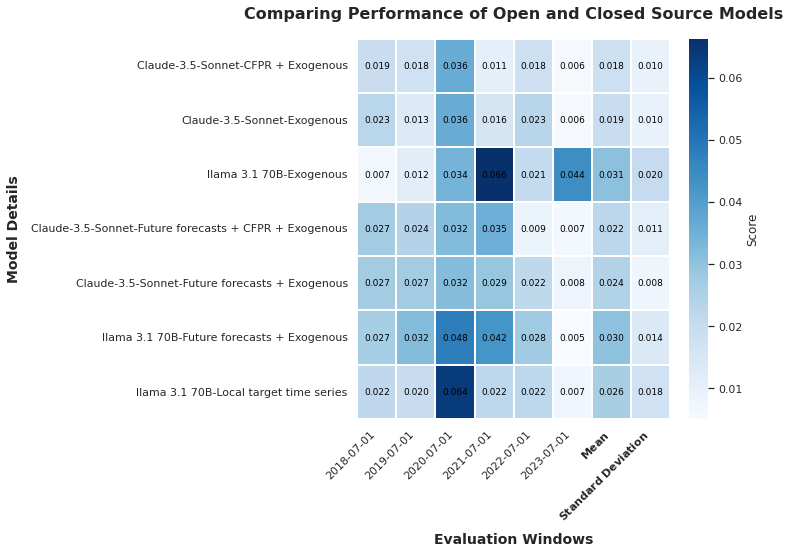

In [188]:
# Step 1: Group by 'inclusion' and filter to keep only those with both "Open Source" and "Close Source" types
filtered_df = expanded_df.groupby('inclusion').filter(lambda x: set(x['type']) == {'Open Source', 'Close Source'})

# Display the filtered DataFrame
filtered_df

best_df = expanded_df.loc[expanded_df.groupby(['inclusion', 'type'])['mean'].idxmin()]



plot_category(best_df, 'category')

In [192]:
expanded_df

,experiment,category,scores,mean,std,model,inclusion,type,eval_window_2018-07-01,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01,eval_window_2023-07-01,eval_overall,eval_std
0,claude-3-5-sonnet-20240620_report_False,food_cpi: Bakery and cereal products (excludin...,"[0.02073924951809224, 0.009312911555855808, 0....",0.028999,0.016868,Claude-3.5-Sonnet,Exogenous,Close Source,0.020739,0.009313,0.027926,0.064062,0.024866,0.027085,0.028999,0.016868
1,llama-3.1-70B_exo_shifted_75_no_headers,food_cpi: Bakery and cereal products (excludin...,"[0.007051510233717095, 0.011508778328986606, 0...",0.030651,0.020383,llama 3.1 70B,Exogenous,Open Source,0.007052,0.011509,0.034153,0.066305,0.020618,0.044267,0.030651,0.020383
2,claude-3-5-sonnet-20240620_report_True,food_cpi: Bakery and cereal products (excludin...,"[0.02073924951809224, 0.009312911555855808, 0....",0.031281,0.018077,Claude-3.5-Sonnet,CFPR + Exogenous,Close Source,0.020739,0.009313,0.022585,0.056580,0.055432,0.023037,0.031281,0.018077
3,claude-3-5-sonnet-20240620_report_True_with_fu...,food_cpi: Bakery and cereal products (excludin...,"[0.017461685586111334, 0.012029143728950656, 0...",0.032751,0.025066,Claude-3.5-Sonnet,Future forecasts + CFPR + Exogenous,Close Source,0.017462,0.012029,0.013280,0.083278,0.044234,0.026224,0.032751,0.025066
4,claude-3-5-sonnet-20240620_report_False_with_f...,food_cpi: Bakery and cereal products (excludin...,"[0.017461685586111334, 0.01024573248629436, 0....",0.032959,0.026227,Claude-3.5-Sonnet,Future forecasts + Exogenous,Close Source,0.017462,0.010246,0.017271,0.085023,0.048239,0.019511,0.032959,0.026227
5,llama-3.1-70B_prices_only_300_no_headers,food_cpi: Bakery and cereal products (excludin...,"[0.01112255896206857, 0.014038112604035119, 0....",0.033145,0.018903,llama 3.1 70B,Local target time series,Open Source,0.011123,0.014038,0.033795,0.067382,0.043403,0.029130,0.033145,0.018903
6,gpt-4o_report_True,food_cpi: Bakery and cereal products (excludin...,"[0.008737717106296169, 0.010787942407354688, 0...",0.034042,0.021648,GPT 4.o,CFPR + Exogenous,Close Source,0.008738,0.010788,0.031907,0.071893,0.047917,0.033008,0.034042,0.021648
7,gpt-4o_report_False,food_cpi: Bakery and cereal products (excludin...,"[0.007458435780564411, 0.01192078857480809, 0....",0.035709,0.026182,GPT 4.o,Exogenous,Close Source,0.007458,0.011921,0.024937,0.069529,0.073324,0.027085,0.035709,0.026182
8,gemini-1.5-pro_report_False,food_cpi: Bakery and cereal products (excludin...,"[0.008759646701409725, 0.01679793296505577, 0....",0.036244,0.023786,Gemini 1.5 Pro,Exogenous,Close Source,0.008760,0.016798,0.052175,0.061451,0.065171,0.013112,0.036244,0.023786
9,llama-3.1-70B_future_forecasts_75_no_headers,food_cpi: Bakery and cereal products (excludin...,"[0.011024352556167214, 0.020650597488930993, 0...",0.037166,0.024509,llama 3.1 70B,Future forecasts + Exogenous,Open Source,0.011024,0.020651,0.028954,0.078274,0.062577,0.021517,0.037166,0.024509


/tmp/ipykernel_6461/1929070900.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'mean': r'$\mathbf{Mean}$', 'std': r'$\mathbf{Standard\ Deviation}$'}, inplace=True)


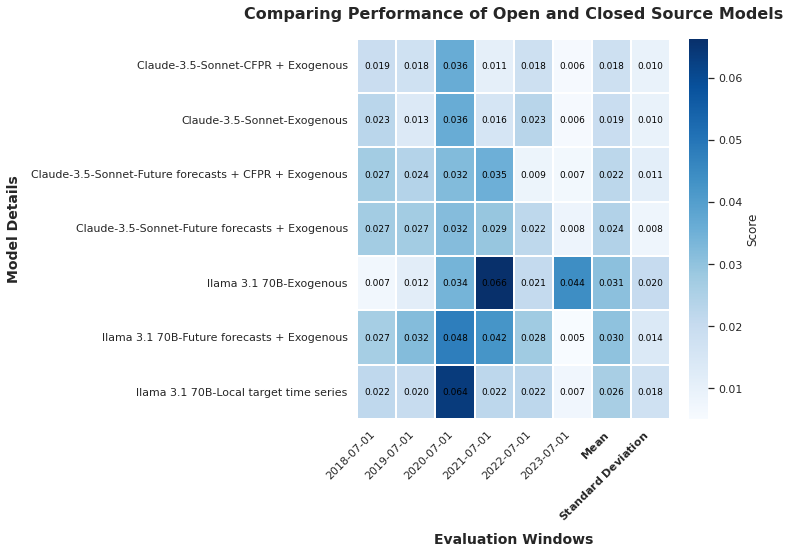

In [195]:
best_df2 = expanded_df.loc[expanded_df.groupby(['type', 'inclusion'])['mean'].idxmin()]
plot_category(best_df2, 'type')